First few rows of the dataset:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimete

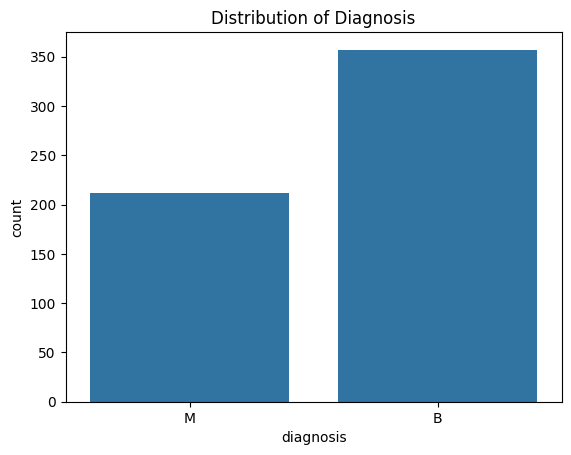


Number of NaN values in diagnosis column:
0


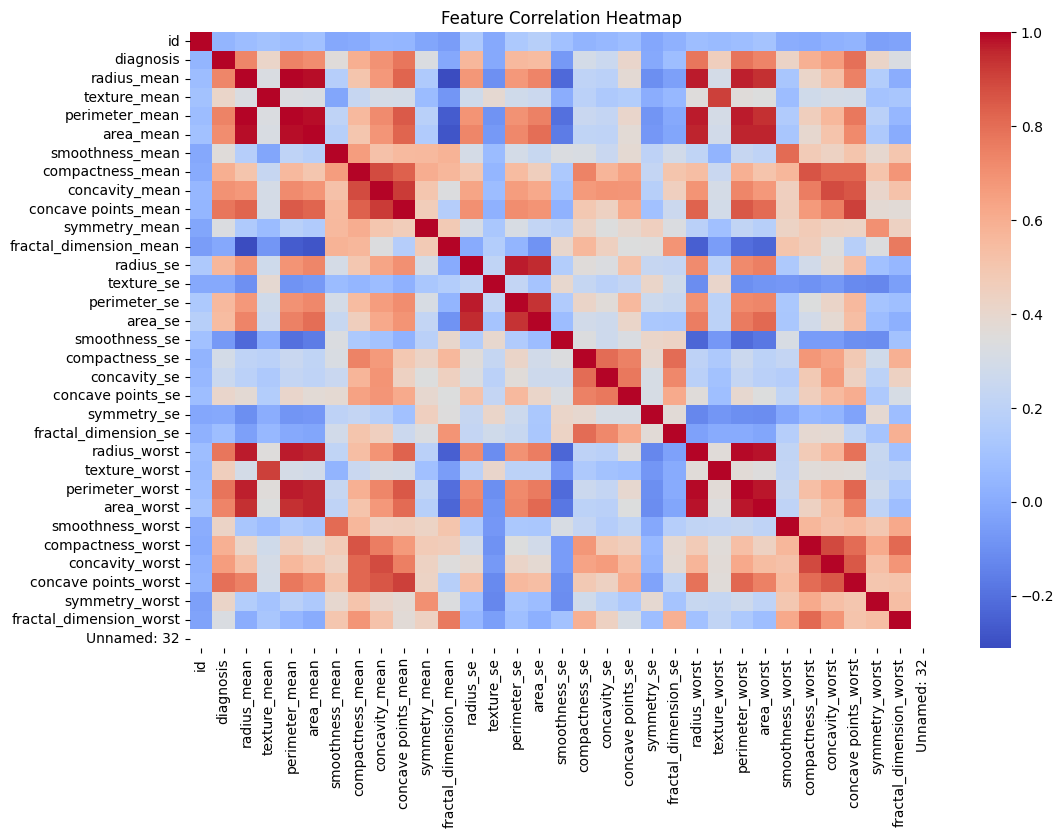

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(



Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Model Evaluation:
Accuracy: 0.9561
Precision: 0.9524
Recall: 0.9302
F1 Score: 0.9412


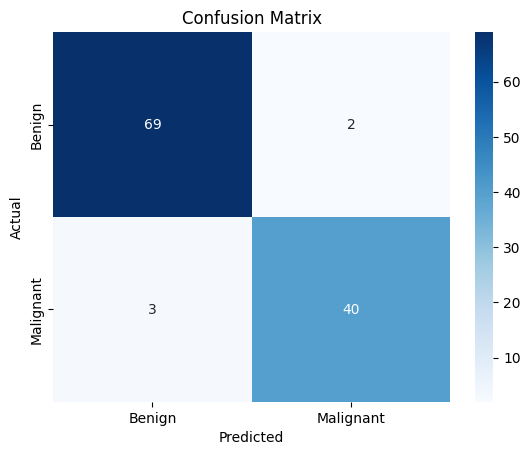

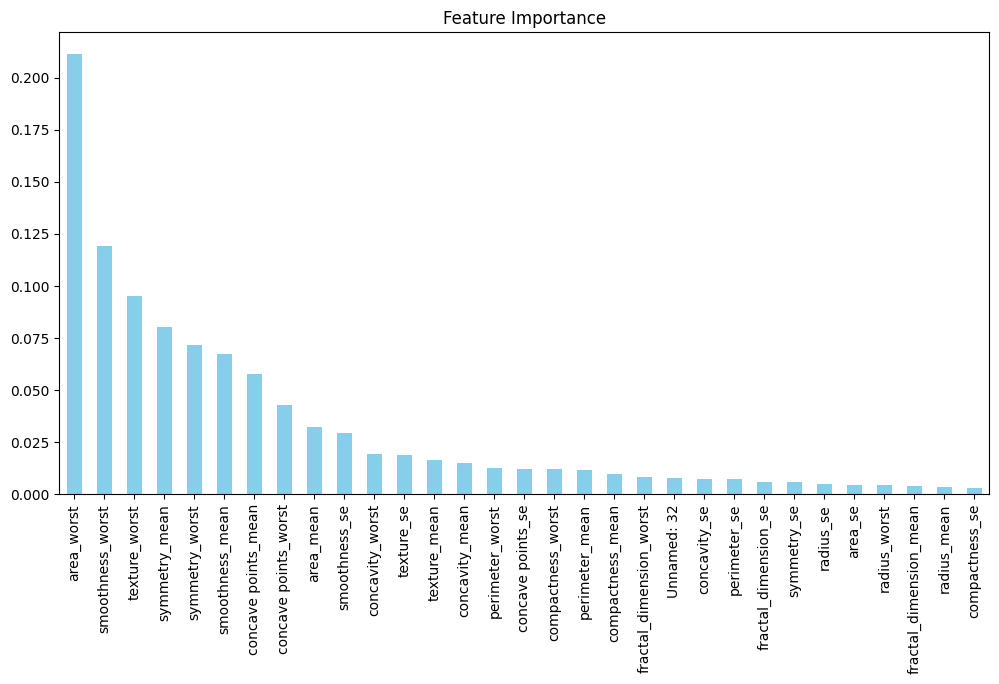


Sample Predictions:
     Actual Diagnosis  Predicted Diagnosis
204                 0                    0
70                  1                    1
131                 1                    1
431                 0                    0
540                 0                    0
Predictions saved to breast_cancer_predictions.csv

Predictions for new data: ['Benign', 'Malignant', 'Malignant', 'Benign', 'Benign']


In [12]:
# Jar 1: Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.utils import estimator_html_repr

# Jar 2: Load and explore the dataset
# Replace this path with your dataset's path
df = pd.read_csv('/content/BreastCancer.csv')

# Show the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Display basic statistics and check for missing values
print("\nDataset statistics:")
print(df.describe())
print("\nMissing values in each column:")
print(df.isnull().sum())

# Check the distribution of the target variable
sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Diagnosis')
plt.show()

# Jar 3: Data Preprocessing

# Encoding the Diagnosis column: Malignant -> 1, Benign -> 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Check for NaN values in 'diagnosis'
print("\nNumber of NaN values in diagnosis column:")
print(df['diagnosis'].isnull().sum())

# Drop rows with NaN values in the target variable
df = df.dropna(subset=['diagnosis'])

# Visualize feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

# Separating features and target variable
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Splitting the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing data in features by using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Feature scaling (important for SVM and other distance-based algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Jar 4: Training multiple classifiers and setting up an ensemble model
# Individual classifiers
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(kernel='linear', random_state=42)

# Hyperparameter tuning for Random Forest (as an example)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_scaled, y_train)
rf_clf = grid_search_rf.best_estimator_
print("\nBest parameters for Random Forest:", grid_search_rf.best_params_)

# Ensemble model using VotingClassifier (Hard Voting)
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('svm', svm_clf)
], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

#Jar 5: Evaluate the ensemble model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("\nModel Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate the ensemble model
evaluate_model(ensemble_model, X_test_scaled, y_test)

# Feature importance (using Random Forest)
feature_importances = pd.Series(rf_clf.feature_importances_, index=X.drop(columns=['id']).columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importance')
plt.show()

# Predict the diagnosis using the ensemble model
y_pred = ensemble_model.predict(X_test_scaled)

# Add predictions to the test set for comparison
results = pd.DataFrame({
    "Actual Diagnosis": y_test,
    "Predicted Diagnosis": y_pred
})
print("\nSample Predictions:")
print(results.head())

# Save predictions to a CSV file
results.to_csv('breast_cancer_predictions.csv', index=False)
print("Predictions saved to breast_cancer_predictions.csv")

# Visualizing the VotingClassifier structure
# Enable HTML representation of estimators
set_config(display='diagram')

# Display the VotingClassifier structure
ensemble_model_html = estimator_html_repr(ensemble_model)
with open("voting_classifier.html", "w") as file:
    file.write(ensemble_model_html)

ensemble_model

# Making predictions for new data
def predict_new_data(new_data):
    new_data_scaled = scaler.transform(new_data)
    predictions = ensemble_model.predict(new_data_scaled)
    return ["Malignant" if pred == 1 else "Benign" for pred in predictions]

# Example of predicting for new data
new_data = X_test[:5]  # Replace with actual new data
predictions = predict_new_data(new_data)
print("\nPredictions for new data:", predictions)

